# Fitting Models to Data - Lotka Volterra Example

## Deterministic Lotka Volterra

In this exercise, we will explore how to fit a model to data using Approximate Bayesian Computation, a likelihood-free method. We will use the Lotka Volterra equations as an instructive biological problem.

The classical Lotka Volterra equations represents the population of prey, $x$, and predators, $y$, as continuous variables which change deterministically according to the equations:
$$\frac{dx}{dt}=\alpha x - \beta x y$$
$$\frac{dy}{dt}=\delta x y - \gamma y$$

First, let's import the modules we'll use throughout:

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp, odeint
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import random
import pyabc
import os
import tempfile
import corner
import sys

Now, let's code up the classic Lotka Volterra ODEs to evaulate the system at timepoints $t$ with parameters $\{\alpha, \beta, \delta, \gamma \}$ and initial conditions $(X_0, Y_0)$

In [2]:
def LotkaVolterraODE(t, x_y, alpha, beta, delta, gamma):
    x, y = x_y

    dx_dt = alpha * x - beta * x * y
    dy_dt = delta * x * y - gamma * y

    return np.array([dx_dt, dy_dt])

def LotkaVolterraDeterministic(
        params,
        InitialConditions,
        t
    ):

    tspan = (np.min(t), np.max(t))

    out = solve_ivp(LotkaVolterraODE, tspan, 
                InitialConditions, t_eval=t, 
                args=params, 
                method='RK45', rtol=10**-6)
    
    out['y'][out['y'] < 0.0] = 0.0

    return out['y']

Before we start trying to fit our model to data, let's play around with different combinations of parameters. Below, you can change the rate parameters $\{\alpha, \beta, \delta, \gamma \}$ and the initial conditions $(X_0, Y_0)$ and see how the populations over time change. Also, plotting the data in "phase space" can be a helpful way to understand the dynamics of the system.

Things to consider:
- How does the periodicity of the oscillations change with the parameters?
- Can you find a combination of parameters where the populations stay fixed (i.e. the steady state solution)?
- How does changing the initial conditions alter the orbits of the system in phase space?

(0.0, 130.89693484726507)

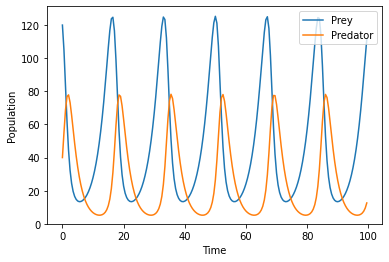

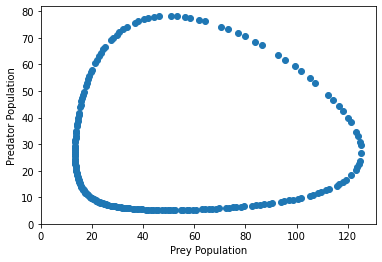

In [3]:
alpha = 0.35
beta = 1.3 * 10**-2
delta = 1 * 10**-2
gamma = 0.5

t = np.arange(0, 100, 0.5)

InitialConditions = np.array([120, 40])

PreyPred = LotkaVolterraDeterministic(
        [alpha, beta, delta, gamma],
        InitialConditions,
        t
    )

fig, ax = plt.subplots()
a = plt.plot(t, PreyPred[0, :])
b = plt.plot(t, PreyPred[1, :])
plt.legend(handles=[a[0], b[0]], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

fig, ax = plt.subplots()
a = plt.scatter(PreyPred[0, :], PreyPred[1, :])
plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

To fit our model to data, we first need some sort of error model, to account for the random measurement error. For simplicity, let's assume that the errors are Poissonian (counting statistics).

In [4]:
def LotkaVolterraDeterministicError(
        params,
        InitialConditions,
        t, 
        rng=None
    ):
    
    if rng is None:
        rng = np.random.default_rng()

    xy = LotkaVolterraDeterministic(params, InitialConditions, t)
    
    return rng.poisson(xy)

(0.0, 152.15)

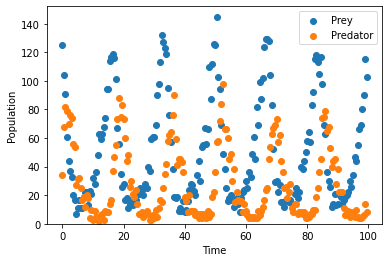

In [5]:
rng = np.random.default_rng()

PreyPredErr = LotkaVolterraDeterministicError([alpha, beta, delta, gamma], 
                                         InitialConditions, t, rng)

fig, ax = plt.subplots()
a = plt.scatter(t, PreyPredErr[0, :])
b = plt.scatter(t, PreyPredErr[1, :])
plt.legend(handles=[a, b], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

Note that for the classical Lotka Volterra system we could write down a likelihood function and use likelihood based methods (MCMC, MLE, etc.), but we're going to use ABC to give an instructive example.

For ABC, we need to define a model that we can use to generate simulated data and a distance metric that we can use to compare the simulated data the the experimental data. In the interests of simplicity, let's assume that we know that $\beta = \delta$, so we only need to infer $\alpha$, $\beta$ and $\gamma$.

In [6]:
def model(parameters, constants):
    alpha = parameters["alpha"]
    gamma = parameters["gamma"]
    beta = parameters["beta"]
    delta = beta
    
    InitialConditions, t, rng = constants
    
    PreyPredErr = LotkaVolterraDeterministicError([alpha, beta, delta, gamma], 
                                         InitialConditions, t, rng)
    return {"data": PreyPredErr}

def distance(x, x0):
    return np.linalg.norm(x["data"] - x0["data"]) / (np.shape(x0["data"])[1] * np.mean(x0["data"]))

Fitting our model to 200 datapoints may take awhile, so in the interests of time, we'll limit ourselves to 11 timepoints over 25 years.

(0.0, 148.6)

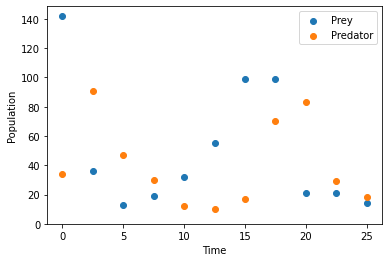

In [7]:
t_eval = np.linspace(0, 25, 11)
rng = np.random.default_rng()
InitialConditions = np.array([120, 40])

constants = [InitialConditions, t_eval, rng]

alphaTrue = 0.35
gammaTrue = 0.5
betaTrue = 10**-2

dataDeterminism = model({"alpha":alphaTrue, "gamma":gammaTrue, "beta":betaTrue}, constants)

fig, ax = plt.subplots()
a = plt.scatter(t_eval, dataDeterminism["data"][0, :])
b = plt.scatter(t_eval, dataDeterminism["data"][1, :])
plt.legend(handles=[a, b], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

Text(0, 0.5, 'Probability density')

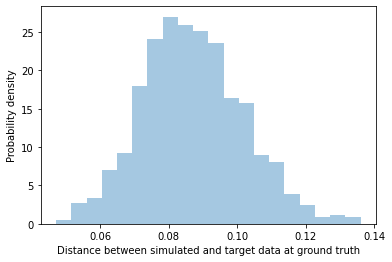

In [8]:
distances = [distance(model({"alpha":alphaTrue, "gamma":gammaTrue, "beta":betaTrue}, constants), dataDeterminism) for i in range(1000)]

fig, ax = plt.subplots()
plt.hist(distances, 20, alpha = 0.4, density = True)
plt.xlabel("Distance between simulated and target data at ground truth")
plt.ylabel("Probability density")

Okay, so let's set our distance threshold to 0.07

We need to define a prior to put on $\alpha$, $\beta$ and $\gamma$. All these parameters are strictly positive and continuous, so let's use a lognormal distribution. For the purposes of the exercise, I'm going to assume that we have some prior knowledge suggesting $\alpha,\gamma \approx 1$ and $\beta \approx 10^{-2}$. In practice, the choice of priors requires a level of domain-specific knowledge (e.g. wider literature, biological limitations etc.), but for a well-formed model, the effect of the prior on the posterior should decrease as we get more data. 

It's often easier to define a prior on the scale of the parameter you're interested in, so let's write a function to convert the mean and standard deviation of the priors to the parameters that scipy accepts (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html)

In [10]:
def lognormal_convert_params(mu, sigma):
    """
    Convert mean/dispersion parameterization of a beta distribution to the ones scipy supports

    """

    if np.any(mu <= 0):
        raise Exception("mu must be greater than 0")
    elif np.any(sigma <= 0) :
        raise Exception("sigma must be greater than 0")
    
    log_mean = np.log(mu) - 0.5 * np.log1p(sigma**2 / mu**2)
    log_std = np.sqrt(np.log1p(sigma**2 / mu ** 2))

    return (log_mean, log_std)

log_mean_alpha, log_std_alpha = lognormal_convert_params(1, 1)
log_mean_gamma, log_std_gamma = lognormal_convert_params(1, 1)
log_mean_beta, log_std_beta = lognormal_convert_params(10**-2, 10**-2)

prior = pyabc.Distribution(alpha=pyabc.RV("lognorm", log_std_alpha, scale=np.exp(log_mean_alpha)), 
                          gamma=pyabc.RV("lognorm", log_std_gamma, scale=np.exp(log_mean_gamma)),
                          beta=pyabc.RV("lognorm", log_std_beta, scale=np.exp(log_mean_beta)))

What do those prior distributions look like? It's important to consider not only the mean of your prior, but also how much probability mass you're putting at very low and very high values (e.g. the degree of uncertainty)

Text(0, 0.5, 'Probability density')

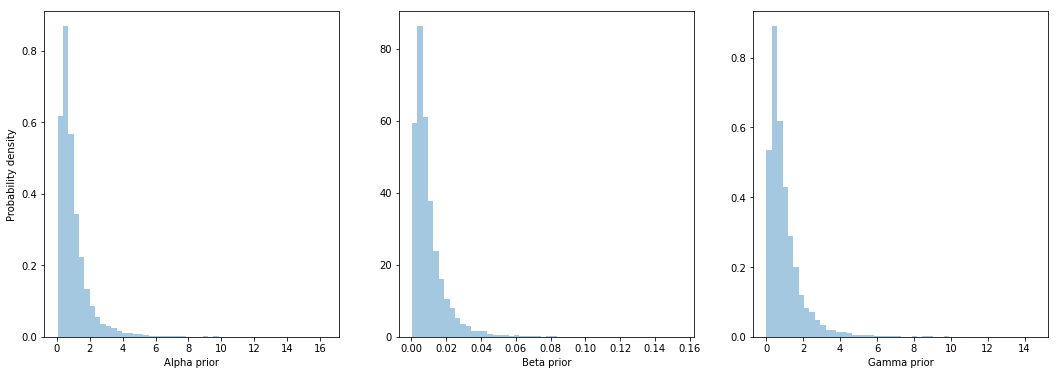

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
a = axes[0].hist(stats.lognorm(log_std_alpha, scale=np.exp(log_mean_alpha)).rvs(10000), 
            50, alpha = 0.4, density = True)
axes[0].set_xlabel("Alpha prior")
b = axes[1].hist(stats.lognorm(log_std_beta, scale=np.exp(log_mean_beta)).rvs(10000), 
            50, alpha = 0.4, density = True)
axes[1].set_xlabel("Beta prior")
c = axes[2].hist(stats.lognorm(log_std_gamma, scale=np.exp(log_mean_gamma)).rvs(10000), 
            50, alpha = 0.4, density = True)
axes[2].set_xlabel("Gamma prior")

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Probability density")

In [12]:
pop_size = 500

modelWrapper = lambda parameters: model(parameters, constants)
abc = pyabc.ABCSMC(modelWrapper, prior, distance, population_size=pop_size)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


In [13]:
db_path = os.path.join(tempfile.gettempdir(), "test.db")
abc.new("sqlite:///" + db_path, dataDeterminism)

ABC.History INFO: Start <ABCSMC id=1, start_time=2022-05-27 16:30:33>


In [14]:
history = abc.run(minimum_epsilon=0.07, max_nr_populations=50)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.00493331e+00.
ABC INFO: Accepted: 500 / 1083 = 4.6168e-01, ESS: 5.0000e+02.
ABC INFO: t: 1, eps: 4.73367505e-01.
ABC INFO: Accepted: 500 / 1106 = 4.5208e-01, ESS: 3.8526e+02.
ABC INFO: t: 2, eps: 4.09124862e-01.
ABC INFO: Accepted: 500 / 1298 = 3.8521e-01, ESS: 3.9605e+02.
ABC INFO: t: 3, eps: 3.53391287e-01.
ABC INFO: Accepted: 500 / 2082 = 2.4015e-01, ESS: 4.2714e+02.
ABC INFO: t: 4, eps: 2.82080511e-01.
ABC INFO: Accepted: 500 / 1533 = 3.2616e-01, ESS: 4.6469e+02.
ABC INFO: t: 5, eps: 2.30399694e-01.
ABC INFO: Accepted: 500 / 1314 = 3.8052e-01, ESS: 4.6243e+02.
ABC INFO: t: 6, eps: 1.90224054e-01.
ABC INFO: Accepted: 500 / 1169 = 4.2772e-01, ESS: 4.7856e+02.
ABC INFO: t: 7, eps: 1.58600448e-01.
ABC INFO: Accepted: 500 / 1220 = 4.0984e-01, ESS: 4.4748e+02.
ABC INFO: t: 8, eps: 1.35881179e-01.
ABC INFO: Accepted: 500 / 1173 = 4.2626e-01, ESS: 4.5400e+02.
ABC INFO: t: 9, eps: 1.18620438e-01.
ABC INFO: Accepted: 500 / 1334 = 3.

Posterior summary - Median (95% CI)
alpha: 0.349 (0.320 - 0.379)
beta: 0.010 (0.009 - 0.011)
gamma: 0.509 (0.476 - 0.543)


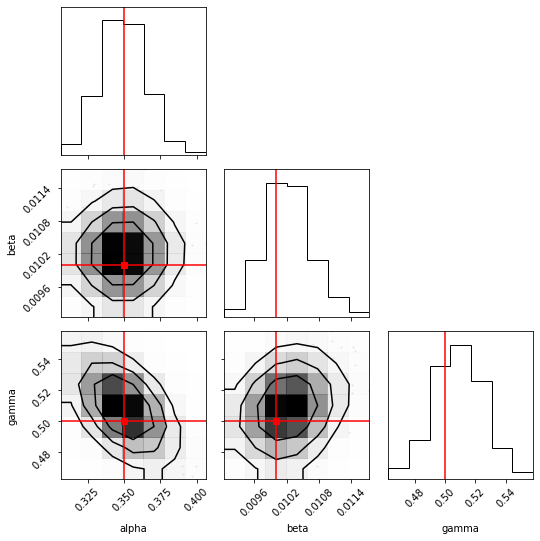

In [17]:
posterior, w = history.get_distribution(m=0)

posterior_median = posterior.median()
posterior_lb = posterior.quantile(0.025)
posterior_ub = posterior.quantile(0.975)

print("Posterior summary - Median (95% CI)")
for col in posterior.columns:
    print(f"{col}: {posterior_median[col]:.3f} ({posterior_lb[col]:.3f} - {posterior_ub[col]:.3f})")

truth_dict = {
    "alpha":alphaTrue,
    "beta":betaTrue,
    "gamma":gammaTrue
}
truth = [truth_dict[col] for col in posterior.columns]

ndims = np.shape(posterior)[1]

# Make the base corner plot
figure = corner.corner(posterior.values, bins=7, smooth=1, labels=posterior.columns)
# Extract the axes
axes = np.array(figure.axes).reshape((ndims, ndims))
# Loop over the diagonal
for i in range(ndims):
    ax = axes[i, i]
    ax.axvline(truth[i], color="r")
# Loop over the histograms
for yi in range(ndims):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(truth[xi], color="r")
        ax.axhline(truth[yi], color="r")
        ax.plot(truth[xi], truth[yi], "sr")
plt.tight_layout()

So using ABC, we can infer the prey's growth rate and the predator's death rate using the classical Lotka Volterra model! 

Having fit our model to data, it is important to check that our model actually does a good job of fitting the data. Obviously, in this case, we defined the model and then drew our data from it, so we know it should be a reasonable fit, but in the case when we're fitting a model to real data this won't necessarily be the case. To compare our model to data, we can overlay the posterior predictive (i.e. the 95% credible interval of our simulated data) atop the targetdata.

First, let's extract the simulated data for each accepted point in the posterior and wrangle it into a more usable shape

In [163]:
posterior_predictive = np.zeros((pop_size, 2, len(t)))

samples_list = history.get_population().get_accepted_sum_stats()
for i in range(len(samples_list)):
    posterior_predictive[i, :, :] = samples_list[i]["data"]

Now, let's calculate the median of the posterior predictive and the 95% credible interval

(0.0, 140.55)

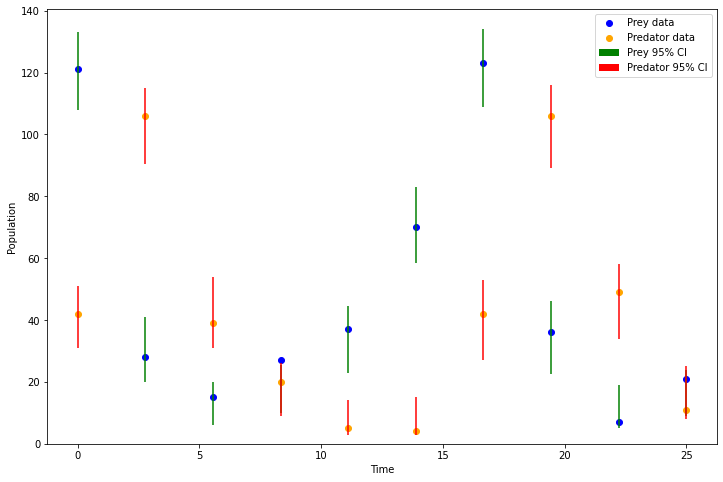

In [164]:
lb = np.percentile(posterior_predictive, 2.5, axis = 0)
ub = np.percentile(posterior_predictive, 97.5, axis = 0)
med = np.median(posterior_predictive, axis = 0)

yerr_lb = med - lb
yerr_ub = ub - med

fig, ax = plt.subplots(figsize=(12, 8))
a = plt.scatter(t, dataDeterminism["data"][0, :], color='blue')
b = plt.scatter(t, dataDeterminism["data"][1, :], color='orange')
c = plt.errorbar(t, med[0, :], yerr = [yerr_lb[0, :], yerr_ub[0, :]], 
             color='green', linestyle='')
d = plt.errorbar(t, med[1, :], yerr = [yerr_lb[1, :], yerr_ub[1, :]], 
             color='red', linestyle='')
plt.legend(handles=[a, b, Patch(facecolor='green'), Patch(facecolor='red')], 
           labels = ['Prey data', 'Predator data', 
                    'Prey 95% CI', 'Predator 95% CI'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

In [ ]:
y_hat_lb = np.percentile(posterior_predictive, 2.5, axis = 0)
y_hat_ub = np.percentile(posterior_predictive, 97.5, axis = 0)

# Overlay the posterior predictive 95% CI atop the data
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, dataDeterminism["data"][0, :], 'blue')
axes[0].fill_between(t, y_hat_lb[:, 0], y_hat_ub[:, 0], alpha=0.2)
axes[0].set_ylabel("Hare Population\n(Thousands)")

axes[1].plot(t, dataDeterminism["data"][1, :].values, 'orange')       
axes[1].fill_between(t, y_hat_lb[:, 1], y_hat_ub[:, 1], alpha=0.2)
axes[1].set_ylabel("Lynx Population\n(Thousands)")
axes[1].set_xlabel("Date")

As expected, the credible interval looks to overlap the targetdata, so we can be pretty confident that our model well represents the data.

The classic Lotka Volterra does a pretty good job capturing certain features of the predator-prey dynamics; however is also quite unrealistic. For instance, in the absence of predators, prey are expected to grow exponentially forever, unbounded by, for example, food. Perhaps more worryingly, the classic model does not allow extinction to occur, a population can get asymptotically close to 0 before recovering.

(0.0, 312.5824799843985)

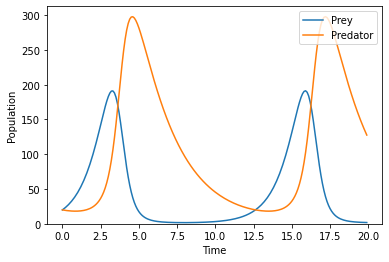

In [8]:
alphaExtinc = 1
betaExtinc = 10**-2
deltaExtinc = 10**-2
gammaExtinc = 0.4

t = np.arange(0, 20, 0.1)

InitialConditionsExtinc = np.array([20, 20])

PreyPredExtinc = LotkaVolterraDeterministic(
        [alphaExtinc, betaExtinc, deltaExtinc, gammaExtinc],
        InitialConditionsExtinc,
        t
    )

fig, ax = plt.subplots()
a = plt.plot(t, PreyPredExtinc[0, :])
b = plt.plot(t, PreyPredExtinc[1, :])
plt.legend(handles=[a[0], b[0]], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

One way to allow for extinction is to turn to a stochastic model, whereby the number of predator and prey are represented by discrete random variables evolving randomly over time. This accounts for both the discrete nature of the problem and random fluctuations.

Theoretically, one could write down the Master equation of the two-dimensional Markov chain that governs this system and attempt to solve it; however, this is computationally difficult, as there are infinite possible states (among other reasons). An alternative approach is to generate a simulation of the predator-prey dynamics that follows the same dynamics as the stochastic Lotka Volterra system.

In the interest of time, I've written a stochastic Gillespie simulation (https://en.wikipedia.org/wiki/Gillespie_algorithm) to model the evolution of the discrete prey and predator populations. For simplicity we've assumed that $\delta=\beta$, so that whenever a prey is consumed a predator gives birth.  The basic structure of the model is to calculate the waiting time until either a prey is born, a predator comsumes a prey and expands or a predator dies. If the waiting time lies within the time interval of the simulation then the event occurs and the time is updated. 

In [26]:
def LotkaVolterraStochastic(        
        params,
        InitialConditions,
        t_eval, 
        rng=None):
    
    if rng is None:
        rng = np.random.default_rng()
    
    # Unpack parameters
    alpha, beta, gamma = params

    # Initialise t variable to count the current time of the system,
    # a t_out variable to count the time of the system when the 
    # output was last updated and a T variable to determine how 
    # long to run the simulation for.
    t = t_eval[0]
    t_out = t_eval[0]
    T = t_eval[-1]
    
    # Define x_y to keep track of the populations of prey and 
    # predators respectively
    x_y = InitialConditions.astype(float)
    
    # Preallocate output array 
    out = np.zeros((2, len(t_eval)))
    out[:, 0] = InitialConditions

    # Define the three types of "events" that our model considers
    events = ['PreyGrowth', 'PredatorConsumePrey', 'PredatorDeath']

    # Use a while loop to model the simulation occurring between t_eval[0]
    # and t_eval[-1]
    while t < T:

        # If both populations have gone extinct, then we can preemptively 
        # end the simulation 
        if np.all(np.abs(x_y) < 0.001):
            break
            
        # If predators go extinct before the prey, then the prey population
        # will undergo a pure birth (Yule) process - this falls out of the 
        # standard Guillespie code below, but will take an exponentially 
        # long time. Instead, we will handle that case separately.
        
        elif abs(x_y[1]) > 0.001:

            # Calculate the rates of the possible state changes 
            weights = np.array([alpha * x_y[0], 
                                beta * x_y[0] * x_y[1], 
                                gamma * x_y[1]])

            # We assume the events have exponential waiting times, calculate 
            # the time until the next event occurs
            twait = 1 / weights.sum() * np.log(1 / random.random())

            if t + twait < T:
                # Randomly choose which event occurs 
                event = random.choices(events, weights)[0]

                if event is 'PreyGrowth':
                    # Increase the prey population by 1
                    x_y[0] += 1
                elif event is 'PredatorConsumePrey':
                    # Decrease the prey population by 1 and
                    # increase the predator population by 1
                    x_y[0] -= 1
                    x_y[1] += 1
                else:
                    # Decrease the predator population by 1
                    x_y[1] -= 1

                # Increase time counter by waiting time
                t += twait

                # This next bit of code is necessary because we have a continuous 
                # time model but fixed evaluation time.

                # Find the first t_eval index that is greater than the last recorded 
                # time and the first t_eval index greater than the current time
                idx_t1 = next(x[0] for x in enumerate(t_eval) if x[1] > t_out)
                idx_t2 = next(x[0] for x in enumerate(t_eval) if x[1] >= t)

                # Loop between idx_t1 and idx_t2 recording all the t_eval
                # timepoints that have fallen between the last event recorded 
                # and the current time
                if idx_t2 > idx_t1:
                    for idx in range(idx_t1, idx_t2):
                        out[:, idx] = x_y

                    t_out = t

            else: 
                idx_t1 = next(x[0] for x in enumerate(t_eval) if x[1] > t_out)
                for idx in range(idx_t1, len(t_eval)):
                    out[:, idx] = x_y
                break
                
        else:
            # If the predator population goes extinct, we will use the known 
            # fact that the population j at time t2 for a pure birth process
            # with initial population i at time t1 follows a negative 
            # binomial distribution with parameters i and exp(-alpha * (t2-t1))
            
            if t >= T:
                break
                
            # Find the next timepoint to be evaluated 
            idx_t = next(x[0] for x in enumerate(t_eval) if x[1] > t)
            t_next = t_eval[idx_t]
            dt = t_next - t
            
            try:
                # The numpy negative binomial distribution is susceptible 
                # to overflow (silently!), so once X is very large just 
                # assume that the growth is deterministically exponential
                dPrey = rng.negative_binomial(int(x_y[0]), np.exp(-alpha*dt ))
                if dPrey >= 0:
                    x_y[0] += dPrey
                else:
                    x_y[0] *= np.exp(alpha * dt)
            except OverflowError as e:
                x_y[0] = sys.float_info.max
            
            out[:, idx_t] = x_y
            
            t += dt

    return out

In [74]:
rng = np.random.default_rng()
t_eval = np.linspace(0, 25, 11)
%timeit LotkaVolterraStochastic([alphaExtinc, betaExtinc, gammaExtinc], InitialConditionsExtinc, t_eval, rng)

44.6 ms ± 4.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's run the simulation a few times and plot the results!

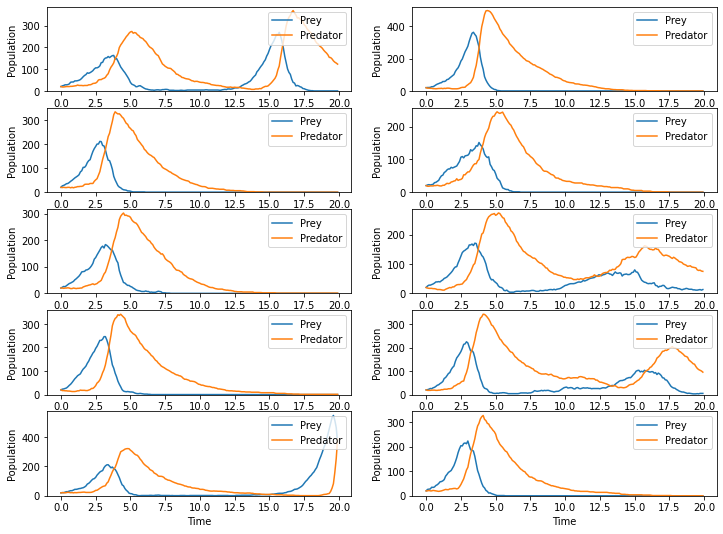

In [203]:
fig, axes = plt.subplots(5, 2, figsize=(12, 9))
axes = np.ravel(axes)
for i in range(10):
    PreyPredStoch = LotkaVolterraStochastic(
            [alphaExtinc, betaExtinc, gammaExtinc],
            InitialConditionsExtinc,
            t, rng
        )
    
    ax = axes[i]
    a = ax.plot(t, PreyPredStoch[0, :])
    b = ax.plot(t, PreyPredStoch[1, :])
    ax.legend(handles=[a[0], b[0]], labels = ['Prey', 'Predator'],
                loc='upper right')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_ylim(bottom=0)

There are some important similarities and differences when comparing the stochastic and discrete model. Namely, the stochastic model now allows for extinctions to occur, but if an extinction does not occur near the trough of the distribution, the stochastic model looks qualitatively similar to the deterministic model (e.g. similar periodicity and amplitude of oscillation). The output of the stochastic model varies from run to run, even without adding any additional measurement error. 

Now try running the above code with $\gamma=2.0$ and $\gamma=2.0$, what do you notice about some of the simulations?

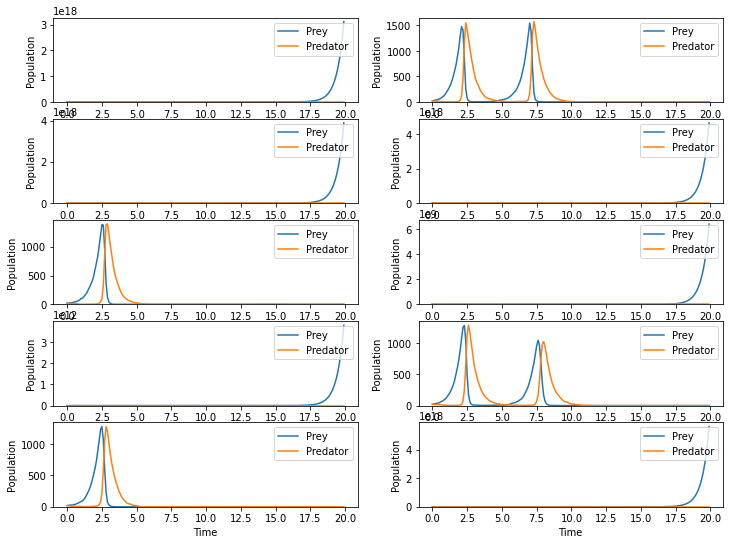

In [115]:
fig, axes = plt.subplots(5, 2, figsize=(12, 9))
axes = np.ravel(axes)
for i in range(10):
    PreyPredStoch = LotkaVolterraStochastic(
            [2.0, betaExtinc, 2.0],
            InitialConditionsExtinc,
            t
        )
    
    ax = axes[i]
    a = ax.plot(t, PreyPredStoch[0, :])
    b = ax.plot(t, PreyPredStoch[1, :])
    ax.legend(handles=[a[0], b[0]], labels = ['Prey', 'Predator'],
                loc='upper right')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_ylim(bottom=0)

Because we can only simulate our model, not write down a closed form likelihood, this is a perfect model to use ABC on!

In [220]:
# t_eval = np.linspace(0, 25, 10)
# PreyPredStoch = LotkaVolterraStochastic(
#         [alphaExtinc, betaExtinc, gammaExtinc],
#         InitialConditionsExtinc,
#         t_eval
#     )

# df = pd.DataFrame(PreyPredStoch.transpose(), columns = ("prey", "predator"))
# df['t'] = t_eval
# df.to_csv("LotkaVolterraStochastic.csv", index=False)

I've generated some data using some hidden parameters for $\alpha$, $\beta$ and $\gamma$ and saved it at LotkaVolterraStochastic.csv - let's load it in and plot it

(0.0, 277.2)

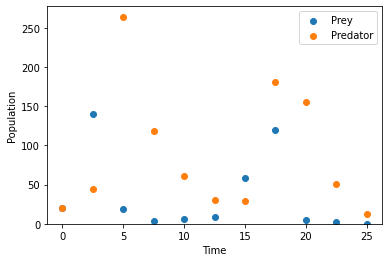

In [10]:
df = pd.read_csv("LotkaVolterraStochastic.csv")
dataStochastic = {"data":df[["prey", "predator"]].values.transpose()}
t_eval = df['t'].values
constantsStochastic = [InitialConditionsExtinc, t_eval, rng]

fig, ax = plt.subplots()
a = plt.scatter(t_eval, dataStochastic["data"][0, :])
b = plt.scatter(t_eval, dataStochastic["data"][1, :])
plt.legend(handles=[a, b], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

Here, you can copy and paste the above ABC model code for the determinstic Lotka Volterra model and modify it to reference the data as dataStochastic and the stcoahstic version of the Lotka Volterra model. I suggest you change the minimum_epsilon to 0.25 and the pop_size to 100, as the stochastic simulation is more computationally expensive and harder to fit, and we want the inference to finish reasonably quickly.

In [11]:
def modelStoch(parameters, constants):
    alpha = parameters["alpha"]
    gamma = parameters["gamma"]
    beta = parameters["beta"]
    
    InitialConditions, t, rng = constants
    
    PreyPredStoch = LotkaVolterraStochastic([alpha, beta, gamma], 
                                         InitialConditions, t, rng)
    return {"data": PreyPredStoch}

In [12]:
pop_size_stoch = 100

log_mean_alpha, log_std_alpha = lognormal_convert_params(1, 1)
log_mean_beta, log_std_beta = lognormal_convert_params(10**-2, 10**-2)

prior = pyabc.Distribution(alpha=pyabc.RV("lognorm", log_std_alpha, scale=np.exp(log_mean_alpha)), 
                          gamma=pyabc.RV("lognorm", log_std_alpha, scale=np.exp(log_mean_alpha)),
                          beta=pyabc.RV("lognorm", log_std_beta, scale=np.exp(log_mean_beta)))

modelWrapperStoch = lambda parameters: modelStoch(parameters, constantsStochastic)
abcStoch = pyabc.ABCSMC(modelWrapperStoch, prior, distance, population_size=pop_size_stoch)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


In [208]:
db_pathStoch = os.path.join(tempfile.gettempdir(), "Stochastic.db")
abcStoch.new("sqlite:///" + db_pathStoch, dataStochastic)

ABC.History INFO: Start <ABCSMC id=9, start_time=2022-05-20 11:13:37>
INFO:ABC.History:Start <ABCSMC id=9, start_time=2022-05-20 11:13:37>


In [209]:
historyStoch = abcStoch.run(minimum_epsilon=0.25, max_nr_populations=50)

ABC INFO: Calibration sample t = -1.
INFO:ABC:Calibration sample t = -1.
ABC INFO: t: 0, eps: 2.17786944e+00.
INFO:ABC:t: 0, eps: 2.17786944e+00.
ABC INFO: Accepted: 100 / 211 = 4.7393e-01, ESS: 1.0000e+02.
INFO:ABC:Accepted: 100 / 211 = 4.7393e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 7.42342674e-01.
INFO:ABC:t: 1, eps: 7.42342674e-01.
ABC INFO: Accepted: 100 / 209 = 4.7847e-01, ESS: 6.3471e+01.
INFO:ABC:Accepted: 100 / 209 = 4.7847e-01, ESS: 6.3471e+01.
ABC INFO: t: 2, eps: 5.74515032e-01.
INFO:ABC:t: 2, eps: 5.74515032e-01.
ABC INFO: Accepted: 100 / 294 = 3.4014e-01, ESS: 6.8258e+01.
INFO:ABC:Accepted: 100 / 294 = 3.4014e-01, ESS: 6.8258e+01.
ABC INFO: t: 3, eps: 5.09578813e-01.
INFO:ABC:t: 3, eps: 5.09578813e-01.
ABC INFO: Accepted: 100 / 294 = 3.4014e-01, ESS: 7.2351e+01.
INFO:ABC:Accepted: 100 / 294 = 3.4014e-01, ESS: 7.2351e+01.
ABC INFO: t: 4, eps: 4.69037802e-01.
INFO:ABC:t: 4, eps: 4.69037802e-01.
ABC INFO: Accepted: 100 / 364 = 2.7473e-01, ESS: 6.5349e+01.
INFO:ABC:Accepted

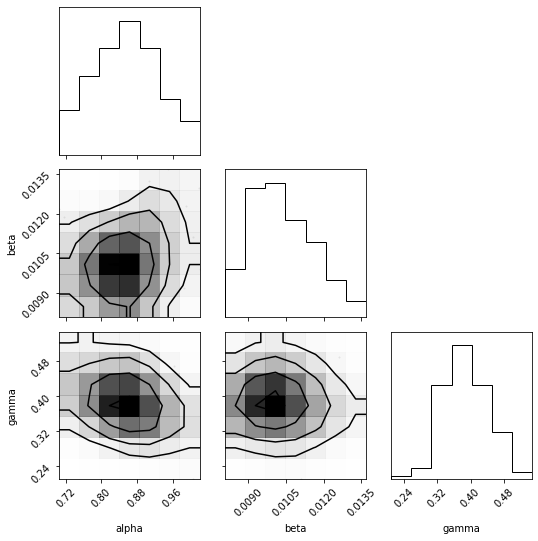

In [210]:
posteriorStoch, wStoch = historyStoch.get_distribution(m=0)
# truth = [alphaTrue, betaTrue, gammaTrue]

ndims = np.shape(posteriorStoch)[1]

# Make the base corner plot
figure = corner.corner(posteriorStoch.values, bins=7, smooth=1, labels=posteriorStoch.columns)
plt.tight_layout()

# Additional Exercises

The following is material that we're unlikely to cover during the session, but may be important to consider when fitting data to real world models.

Naively, one may expect that as you increase the amount of data you are fitting your model to, the easier it becomes to fit. One of the difficulties of ABC is that as you increase the number of stochastic datapoints you are fitting, the less likely that your simulation outputs are very close to all of them at once, and so it can take an exponentially longer time to fit your model. This is known as the curse of dimensionality. 

(0.0, 311.85)

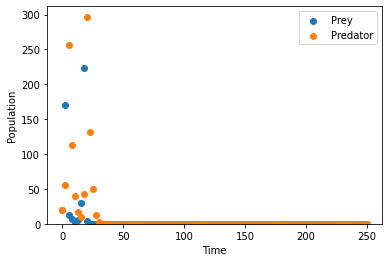

In [14]:
t_eval2 = np.linspace(0, 250, 101)
constantsStochHighDim = [InitialConditionsExtinc, t_eval2, rng]
dataStochHighDim = modelStoch({"alpha":alphaExtinc, 
                                   "gamma":gammaExtinc, 
                                   "beta":betaExtinc}, 
                              constantsStochHighDim)

fig, ax = plt.subplots()
a = plt.scatter(t_eval2, dataStochHighDim["data"][0, :])
b = plt.scatter(t_eval2, dataStochHighDim["data"][1, :])
plt.legend(handles=[a, b], labels = ['Prey', 'Predator'],
            loc='upper right')
plt.xlabel('Time')
plt.ylabel('Population')
ax.set_ylim(bottom=0)

In [28]:
modelWrapperStochHighDim = lambda parameters: modelStoch(parameters, constantsStochHighDim)
abcStochHighDim = pyabc.ABCSMC(modelWrapperStochHighDim, prior, distance, population_size=pop_size_stoch)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


In [29]:
db_pathStochHighDim = os.path.join(tempfile.gettempdir(), "StochasticHighDim.db")
abcStochHighDim.new("sqlite:///" + db_pathStochHighDim, dataStochHighDim)

ABC.History INFO: Start <ABCSMC id=4, start_time=2022-05-20 11:42:47>


In [30]:
historyStochHighDim = abcStochHighDim.run(minimum_epsilon=0.25, max_nr_populations=50)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 4.52790700e+00.
ABC INFO: Accepted: 100 / 186 = 5.3763e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 8.44538501e-01.
ABC INFO: Accepted: 100 / 239 = 4.1841e-01, ESS: 6.9156e+01.
ABC INFO: t: 2, eps: 6.41192601e-01.
ABC INFO: Accepted: 100 / 262 = 3.8168e-01, ESS: 7.5811e+01.
ABC INFO: t: 3, eps: 5.90655994e-01.
ABC INFO: Accepted: 100 / 386 = 2.5907e-01, ESS: 7.6327e+01.
ABC INFO: t: 4, eps: 5.55938206e-01.
ABC INFO: Accepted: 100 / 369 = 2.7100e-01, ESS: 7.7552e+01.
ABC INFO: t: 5, eps: 5.39637873e-01.
ABC INFO: Accepted: 100 / 483 = 2.0704e-01, ESS: 6.9517e+01.
ABC INFO: t: 6, eps: 5.29283777e-01.
ABC INFO: Accepted: 100 / 702 = 1.4245e-01, ESS: 2.5035e+01.
ABC INFO: t: 7, eps: 5.03445532e-01.
ABC INFO: Accepted: 100 / 2176 = 4.5956e-02, ESS: 1.8407e+01.
ABC INFO: t: 8, eps: 4.38335693e-01.
ABC INFO: Accepted: 100 / 3813 = 2.6226e-02, ESS: 7.8596e+01.
ABC INFO: t: 9, eps: 3.54829951e-01.
ABC INFO: Accepted: 100 / 2913 = 3.4329e-0

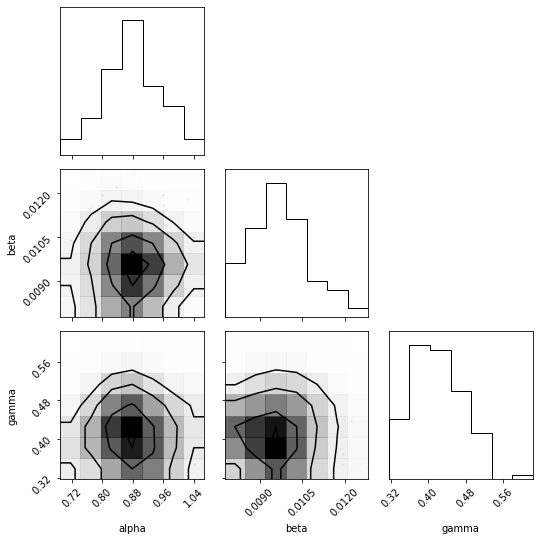

In [31]:
posteriorStochHighDim, wStochHighDim = historyStochHighDim.get_distribution(m=0)
# truth = [alphaTrue, betaTrue, gammaTrue]

ndims = np.shape(posteriorStochHighDim)[1]

# Make the base corner plot
figure = corner.corner(posteriorStochHighDim.values, bins=7, smooth=1, labels=posteriorStochHighDim.columns)
plt.tight_layout()

In [55]:
YPredictor = pyabc.predictor.LinearPredictor
distanceReg = pyabc.distance.PNormDistance(
        p=1,
        # regression-based summary statistics
        sumstat=pyabc.sumstat.PredictorSumstat(
            # regression model used
            predictor=YPredictor(),
            # when to fit the regression model
            fit_ixs=pyabc.util.EventIxs(sims=200),
        ),
    )

In [69]:
class IdSumstat(pyabc.Sumstat):
    """Identity summary statistic."""

    def __call__(self, data: dict) -> np.ndarray:
        # shape (n, dim)
        return np.transpose(data["data"])

distanceWass = pyabc.SlicedWassersteinDistance(
        metric="sqeuclidean",
        p=2,
        sumstat=IdSumstat(),
        # number of random projections for Monte-Carlo integration
        n_proj=10,
    )

In [59]:
abcStochHighDim2 = pyabc.ABCSMC(modelWrapperStochHighDim, prior, distanceReg, population_size=pop_size_stoch)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


In [60]:
db_pathStochHighDim2 = os.path.join(tempfile.gettempdir(), "StochasticHighDim2.db")
abcStochHighDim2.new("sqlite:///" + db_pathStochHighDim2, dataStochHighDim)

ABC.History INFO: Start <ABCSMC id=11, start_time=2022-05-20 12:07:27>


In [61]:
historyStochHighDim2 = abcStochHighDim2.run(minimum_epsilon=0.25, max_nr_populations=50)

ABC INFO: Calibration sample t = -1.
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 4.39050293e+00.
ABC INFO: Accepted: 100 / 155 = 6.4516e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 3.73724365e+00.
ABC INFO: Accepted: 100 / 219 = 4.5662e-01, ESS: 5.6491e+01.
ABC INFO: t: 2, eps: 3.45455127e+00.
ABC INFO: Accepted: 100 / 609 = 1.6420e-01, ESS: 5.0551e+01.
ABC INFO: t: 3, eps: 2.90906386e+00.
ABC INFO: Accepted: 100 / 1468 = 6.8120e-02, ESS: 5.2041e+01.
ABC INFO: t: 4, eps: 2.15543884e+00.
ABC INFO: Accepted: 100 / 2095 = 4.7733e-02, ESS: 5.2084e+01.
ABC INFO: t: 5, eps: 1.43672263e+00.
ABC INFO: Accepted: 100 / 4114 = 2.4307e-02, ESS: 6.7926e+01.
ABC INFO: t: 6, eps: 1.05182110e+00.
ABC INFO: Accepted: 100 / 4093 = 2.4432e-02, ESS: 5.1508e+01.
ABC INFO: t: 7, eps: 7.42220386e-01.
ABC INFO: Accepted: 100 / 7007 = 1.4271e-02, ESS: 2.0116e+01.
ABC INFO: t: 8, eps: 4.04578823e-01.
ABC INFO: Accepted: 100 / 19592 = 5.1041e-03, ESS: 5.9587e+01.
ABC INFO: t: 

KeyboardInterrupt: 

  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/pro

  File "/Users/cgabbutt/Dropbox (ICR)/Calum/PhDproject/Conferences/ISEEC Sumer School 2022/FitModelsData/lib/python3.7/site-packages/pyabc/model.py", line 205, in accept
    result = self.summary_statistics(t, pars, sum_stat_calculator)
  File "/Users/cgabbutt/Dropbox (ICR)/Calum/PhDproject/Conferences/ISEEC Sumer School 2022/FitModelsData/lib/python3.7/site-packages/pyabc/model.py", line 205, in accept
    result = self.summary_statistics(t, pars, sum_stat_calculator)
  File "/Users/cgabbutt/Dropbox (ICR)/Calum/PhDproject/Conferences/ISEEC Sumer School 2022/FitModelsData/lib/python3.7/site-packages/pyabc/model.py", line 205, in accept
    result = self.summary_statistics(t, pars, sum_stat_calculator)
  File "/Users/cgabbutt/Dropbox (ICR)/Calum/PhDproject/Conferences/ISEEC Sumer School 2022/FitModelsData/lib/python3.7/site-packages/pyabc/model.py", line 205, in accept
    result = self.summary_statistics(t, pars, sum_stat_calculator)
  File "/Users/cgabbutt/Dropbox (ICR)/Calum/PhDproje

  File "/var/folders/wl/vx5m5g3n7hl_gn37634vcs2d1m1392/T/ipykernel_25190/1801424058.py", line 38, in LotkaVolterraStochastic
    if np.all(np.abs(x_y) < 0.001):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/random.py", line 366, in choices
    for i in range(k)]
KeyboardInterrupt
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/random.py", line 366, in choices
    for i in range(k)]
  File "/Users/cgabbutt/Dropbox (ICR)/Calum/PhDproject/Conferences/ISEEC Sumer School 2022/FitModelsData/lib/python3.7/site-packages/numpy/core/_methods.py", line 48, in _sum
    return umr_sum(a, axis, dtype, out, keepdims, initial, where)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/random.py", line 360, in choices
    if len(cum_weights) != len(population):
KeyboardInterrupt
  File "/Users/cgabbutt/Dropbox (ICR)/Calum/PhDproject/Conferences/ISEEC Sumer School 2022/FitModelsData/lib/python3.7/site-packages/numpy/core/_methods.py",

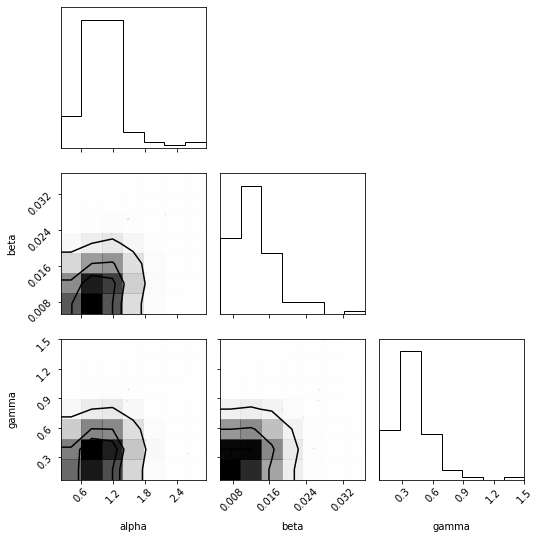

In [54]:
posteriorStochHighDim2, wStochHighDim2 = historyStochHighDim2.get_distribution(m=0)
# truth = [alphaTrue, betaTrue, gammaTrue]

ndims = np.shape(posteriorStochHighDim2)[1]

# Make the base corner plot
figure = corner.corner(posteriorStochHighDim2.values, bins=7, smooth=1, labels=posteriorStochHighDim2.columns)
plt.tight_layout()

Text(0, 0.5, 'Probability density')

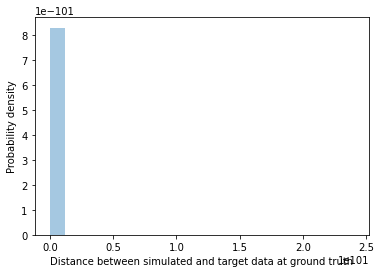

In [70]:
distancesWass = [distanceWass(modelWrapperStochHighDim({"alpha":alphaExtinc, "gamma":gammaExtinc, "beta":betaExtinc}), dataStochHighDim) 
                 for i in range(1000)]

fig, ax = plt.subplots()
plt.hist(distancesWass, 20, alpha = 0.4, density = True)
plt.xlabel("Distance between simulated and target data at ground truth")
plt.ylabel("Probability density")